In [1]:
%reload_ext autoreload
%autoreload 2

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers
from dominoes import datasets
from dominoes import training
from dominoes.analysis import transformer_analysis as ta

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output
# 4. Analyze why the abrupt increases in loss happen during pointer demonstration
#    - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the loss

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------


In [266]:
# Immediate to-do
# 1. Finish up transition to REINFORCE algorithm for pointer sequencing
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
#    - Predict this with a value function too. 
# 4. Divide pointer network into "encoder" and "decoder" blocks to reuse the encoder (and append value)
# 5. Try new versions of pointer attention:
#    - simple attention (not a transformer layer) then single (N -> 1) FF layer
#    - dot product between decoder_context and encoded_representations then softmax over that
# --
# also
# --
# 1. Test simpler TD agents on a probability of winning based value, rather than score!


# Good Coding Practice:
# 1. Convert measure reward to class
# 2. Make a class for all these methods going to the experiments (batch, pad, etc.)

# Representations:
# 1. Make clean and nicely stored system for representing outputs in hand sequencing

In [165]:
# method for training agent
numPlayers = 4
highestDominoe = 9
shuffleAgents = True
trainGames = 10
trainRounds = 10

# open game with basic value agent playing against three default dominoe agents 
agents=(da.basicValueAgent, None, None, None)
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, shuffleAgents=shuffleAgents, agents=agents, defaultAgent=da.dominoeAgent, device=device)
game.getAgent(0).setLearning(True)
game.getAgent(0).setReplay(False)

# run training rounds
trainWinnerCount = np.zeros(numPlayers)
trainHandWinnerCount = np.zeros((trainGames,numPlayers))
trainScoreTally = np.zeros((trainGames,numPlayers))
for gameIdx in tqdm(range(trainGames)):
    game.playGame(rounds=trainRounds)
    trainWinnerCount[game.currentWinner] += 1
    trainHandWinnerCount[gameIdx] += np.sum(game.score==0,axis=0)
    trainScoreTally[gameIdx] += game.currentScore

results = {
    'trainWinnerCount':trainWinnerCount, 
    'trainHandWinnerCount':trainHandWinnerCount,
    'trainScoreTally':trainScoreTally,
}

# And plot results
filter = lambda x : savgol_filter(x, 20, 1)
trainRounds = args.train_rounds if args.train_rounds is not None else highestDominoe+1
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(args.train_games), 
           filter(results['trainScoreTally'][:,0]/trainRounds), 
           c='b', label=args.value_agent)
ax[0].plot(range(args.train_games), 
           filter(np.mean(results['trainScoreTally'][:,1:],axis=1)/trainRounds),
           c='k', label=f"{args.opponent}")
ax[0].set_ylim(0)
ax[0].set_xlabel('Training Games')
ax[0].set_ylabel('Training Score Per Hand')
ax[0].legend(loc='best')

ax[1].plot(range(args.train_games), 
           filter(results['trainHandWinnerCount'][:,0]), 
           c='b', label=args.value_agent)
ax[1].plot(range(args.train_games), 
           filter(np.mean(results['trainHandWinnerCount'][:,1:],axis=1)), 
           c='k', label=f"{args.opponent}")
ax[1].set_ylim(0)
ax[1].set_xlabel('Training Games')
ax[1].set_ylabel('Training Num Won Hands')
ax[1].legend(loc='best')

plt.show()

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:21<00:09,  3.09s/it]


KeyboardInterrupt: 

In [1]:
# order of operations:
# 4. write documentation file explaining the experiment
# 5. develop these analyses, focus on pointer layer because that's where the new architectures are|

In [23]:
from pathlib import Path
pointer_methods = ['PointerStandard', 'PointerDot']

resPath = Path('experiments') / 'savedResults'
savePath = Path('.') / 'experiments' / 'savedNetworks'
results = np.load(resPath / 'pointerArchitectureComparison.npy', allow_pickle=True).item()
nets = []
for pointer_method in pointer_methods:
    name = f"pointerArchitectureComparison_{pointer_method}.pt"
    nets.append(torch.load(savePath / name))
nets = [net.to(device) for net in nets]

In [24]:
outs = ta.processData(nets, 2048)
embedded, encoded, intermediate, decoder_context, decoder_input, scores, choices = outs

In [72]:
# make dominoe x embedding array to figure out sort index for units
emb_dim = ptr_encoded.size(2)
scatter_index = torch.tensor(selection, dtype=torch.long).view(-1,1)
dom_rep_encoded = torch.zeros((numDominoes, emb_dim), dtype=torch.float)
dom_rep_counts = torch.zeros((numDominoes, 1), dtype=torch.long)
dom_rep_encoded.scatter_add_(0, scatter_index.expand(-1, emb_dim), ptr_encoded.view(-1, emb_dim))
dom_rep_counts.scatter_add_(0, scatter_index, torch.ones_like(scatter_index, dtype=torch.long))
dom_rep_encoded /= dom_rep_counts # average encoding of each dominoe

In [83]:
# sort encoding and decodings
proj_value = torch.tensor(dominoeValue, dtype=torch.float) @ dom_rep_encoded
idx_dom_sort = np.argsort(dominoeValue)
idx_enc_sort = torch.argsort(-proj_value)

evals, evecs = torch.linalg.eigh(torch.cov(dom_rep_encoded.T))
idx_evals = torch.argsort(-evals)
evals = evals[idx_evals]
evecs = evecs[:, idx_evals]
idx_pca = torch.argsort(evecs[:,0])

(48, 1)


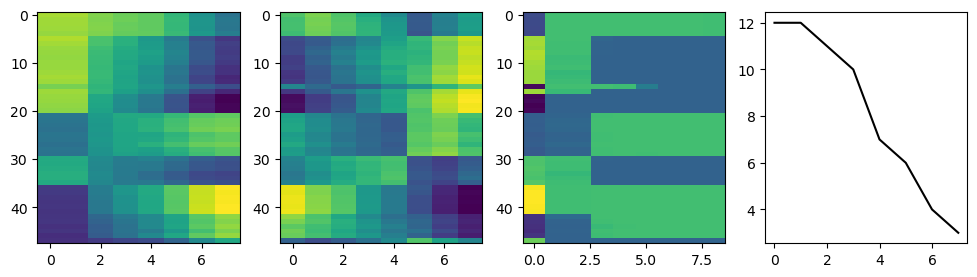

In [74]:
# pick batch index and show data
bidx = 2
batch_dominoes = listDominoes[selection[bidx]]
batch_value = np.sum(batch_dominoes, axis=1)

combined = ptr_encoded[bidx] + ptr_decoded[bidx][:,0]
ctrans = np.tanh(combined.T[idx_enc_sort][:,choices[bidx]].detach().numpy())
vtrans = nets[0].pointer.pointer.vt.weight.detach().cpu().numpy()[0, idx_enc_sort].reshape(-1,1)
print(vtrans.shape)

plt.close('all')
fig, ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(ptr_encoded[bidx].T[idx_enc_sort][:,choices[bidx]].detach().numpy(), aspect='auto')
ax[1].imshow(ptr_decoded[bidx][idx_enc_sort].detach().numpy(), aspect='auto')
ax[2].imshow(np.hstack((vtrans, ctrans)), aspect='auto')
ax[3].plot(range(len(batch_value)), batch_value[choices[bidx]], color='k', label='dominoe value')
plt.show()

torch.Size([512, 8, 48])
torch.Size([512, 8])
torch.Size([512, 48, 8])


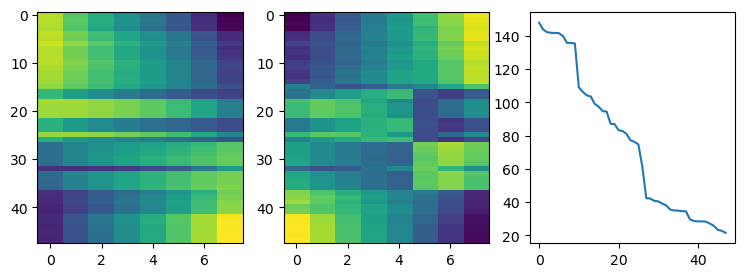

In [84]:
print(ptr_encoded.shape)
print(choices.shape)
print(ptr_decoded.shape)

srt_ptr_encoded = torch.gather(ptr_encoded, 1, choices.unsqueeze(2).expand(-1,-1,ptr_encoded.size(2)))

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(9,3))
ax[0].imshow(torch.mean(srt_ptr_encoded, axis=0).T[idx_pca].detach().numpy(), aspect='auto')
ax[1].imshow(torch.mean(ptr_decoded, axis=0)[idx_pca].detach().numpy(), aspect='auto')
ax[2].plot(range(ptr_encoded.size(2)), -torch.sort(-torch.var(ptr_encoded, dim=(0,1)))[0].detach().numpy())
plt.show()


In [73]:
# the above is the right idea. need to write good code to:
# -- take a full batch of data (ensuring that each dominoe is represented) and sort activations 
#             - using rastermap, PCA, basic sort projection method
# -- show the encoding of different batches with the decoder dot representation
# -- show the decoder update rules (study the decoder transformer) NOTE THAT THIS IS COMPLICATED!!!
# -- show how encoding of the same dominoe changes depending on what other dominoes are present

In [ ]:
# and need to update interpretability code (immediatley above and in analysis module) to include breakdown of all the pointer_method layers

In [29]:
# experiment: 
# after training, switch the encoders between the pointerDot and pointerStandard and just train the decoder to see if the pointer layer improves
# performance by it's effect on the encoding layer during the training phase...

In [118]:
# first add a plot showing the average encoding and decoding across the different positions
# use above ideas and change the eigenspectrum plots to variance plots for each individual dimension

In [100]:
# I also need to compare the performance with the GRU and LSTM!

Training network...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]


Testing network...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


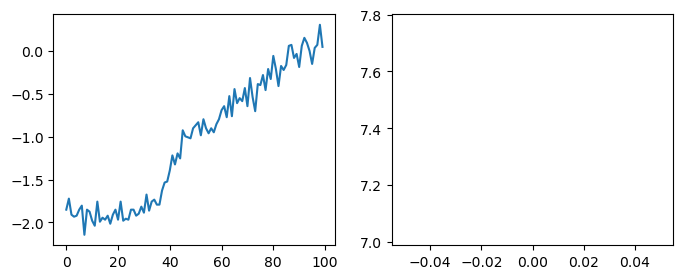

In [63]:
# test sequencer code
def get_gamma_transform(gamma, N, B):
    exponent = torch.arange(N).view(-1,1) - torch.arange(N).view(1,-1)
    gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(B, -1, -1)
    return gamma_transform
    
# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)

handSize = 10
batchSize = 512
null_token=False
available_token=True
num_output = 1 #copy(handSize)
ignore_index = -1

input_dim = (2 if not(available_token) else 3)*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 96
heads = 8
expansion = 2
encoding_layers = 2
greedy = True
temperature = 15.0
contextual_encoder = True # use available token as a context

gamma = 1.0
gamma_transform = get_gamma_transform(gamma, num_output, batchSize).to(device)
    
trainEpochs = 100
testEpochs = 1

alpha = 1e-3
weight_decay = 1e-5

# Create a pointer network
net = transformers.PointerNetwork(input_dim, embedding_dim, encoding_layers=encoding_layers, heads=heads, expansion=expansion, 
                                  kqnorm=True, contextual_encoder=contextual_encoder, decoder_method='transformer', 
                                  greedy=greedy, temperature=temperature, pointer_method='PointerStandard', thompson=True)
net = net.to(device)

# Create an optimizer, Adam with weight decay is pretty good
optimizer = torch.optim.Adam(net.parameters(), lr=alpha, weight_decay=weight_decay)

# Train network
print("Training network...")
trainReward = torch.zeros(trainEpochs)
testReward = torch.zeros(testEpochs)
for epoch in tqdm(range(trainEpochs)):
    # zero gradients
    optimizer.zero_grad()

    # generate input batch
    batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, return_target=False, null_token=null_token,
                                   available_token=available_token, ignore_index=ignore_index, return_full=True)

    # unpack batch tuple
    input, _, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)
    
    # divide input into main input and context
    x, context = input[:, :-1], input[:, [-1]]
    input = (x, context)
    
    # propagate it through the network
    out_scores, out_choices = net(input, max_output=num_output)
    
    # measure rewards for each sequence
    rewards = training.measureReward_sequencer(available, listDominoes[selection], out_choices, value_method='3', normalize=False)
    G = torch.bmm(rewards.unsqueeze(1), gamma_transform).squeeze(1)
    logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2) # log-probability for each chosen dominoe
    
    # do backward pass on J
    J = -torch.sum(logprob_policy * G)
    J.backward()

    # update network
    optimizer.step()

    trainReward[epoch] = torch.mean(torch.sum(rewards, dim=1))

# Test network - same thing as in testing but without updates to model
with torch.no_grad():
    print("Testing network...")
    net.setTemperature(1.0)
    net.setThompson(False)
    for epoch in tqdm(range(testEpochs)):
        # generate input batch
        batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, return_target=False,
                                       null_token=null_token, available_token=available_token, ignore_index=ignore_index, return_full=True)

        # unpack batch tuple
        input, _, _, _, _, selection, available = batch

        # move to correct device
        input = input.to(device)
        
        # divide input into main input and context
        x, context = input[:, :-1], input[:, [-1]]
        input = (x, context)
        
        # propagate it through the network
        out_scores, out_choices = net(input, max_output=num_output)
        
        # measure rewards for each sequence
        rewards = training.measureReward_sequencer(available, listDominoes[selection], out_choices, value_method='dominoe', normalize=False)
        
        testReward[epoch] = torch.mean(torch.sum(rewards, dim=1))


plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(range(trainEpochs), trainReward.detach().cpu().numpy())
ax[1].plot(range(testEpochs), testReward.detach().cpu().numpy())
plt.show()

In [64]:
torch.mean(out_scores.squeeze(1), dim=0)

tensor([-22.7722, -22.3055, -22.2269, -22.2100, -22.3130, -20.9817, -20.8811,
        -21.5324, -20.9739, -22.0221], device='cuda:0')

In [133]:
# Update all pointerArchitectureComparison files to do multiple runs (usually 5...)
# Check RL implementation of the TSP problem
input, target, xy, dists = datasets.tsp_batch(10, 5, return_full=True)
choices = torch.randint(0,5,(10,5))

In [134]:
new_city, distance = training.measureReward_tsp(dists, choices)

In [128]:
ii = 1
print("Distance:\n", dists[ii])
print("Choices:\n", choices[ii])
print("New City:\n", new_city[ii])
print("Distance Step:\n", distance[ii])

check_distance = torch.zeros(5)
for i in range(1, 5):
    check_distance[i] = dists[ii][choices[ii][i], choices[ii][i-1]]
print("Check Dist:\n", check_distance)

Distance:
 tensor([[0.0000, 0.7632, 0.6978, 0.4117, 0.3546],
        [0.7632, 0.0000, 0.7558, 0.4460, 0.8187],
        [0.6978, 0.7558, 0.0000, 0.8130, 1.0162],
        [0.4117, 0.4460, 0.8130, 0.0000, 0.3728],
        [0.3546, 0.8187, 1.0162, 0.3728, 0.0000]], dtype=torch.float64)
Choices:
 tensor([2, 2, 4, 4, 2])
New City:
 tensor([ 1., -1.,  1., -1., -1.])
Distance Step:
 tensor([0.0000, 0.0000, 1.0162, 0.0000, 1.0162])
Check Dist:
 tensor([0.0000, 0.0000, 1.0162, 0.0000, 1.0162])


In [161]:
# can edit this for each machine it's being used on
resPath = Path('.') / 'experiments' / 'savedResults'
        
# method for returning the name of the saved network parameters (different save for each possible opponent)
def getFileName(extra=None):
    baseName = "ptrArchComp_TSP_RL"
    if extra is not None:
        baseName = baseName + f"_{extra}"
    return baseName
    
results = np.load(resPath / (getFileName()+'.npy'), allow_pickle=True).item()

In [156]:
for k in results.keys(): print(k)

trainTourLength
testTourLength
trainTourComplete
testTourComplete
trainTourValidLength
testTourValidLength
trainRewardByPosition
testRewardByPosition
trainScoreByPosition
testScoreByPosition


In [157]:
results['trainTourComplete'].shape

torch.Size([8000, 6, 5])

In [159]:
torch.any(~results['trainTourComplete'])

TypeError: ~ (operator.invert) is only implemented on integer and Boolean-type tensors

In [162]:
torch.unique(results['trainTourComplete'])

tensor([1.])